Authors: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pingouin import madmedianrule
from cardioception.plotting import hrd_convergence, plot_confidence
%matplotlib inline

no display found. Using non-interactive Agg backend


**Import data**

In [2]:
results_df = pd.read_csv('nanna.txt')

# Plot convergence

In [3]:
results_df = results_df.dropna()

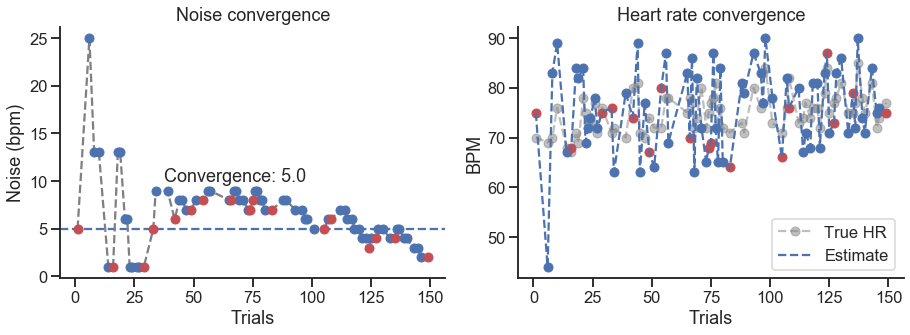

In [4]:
hrd_convergence(results_df[results_df.StairCond==1])
plt.savefig('clara_stari1.png', dpi=600)

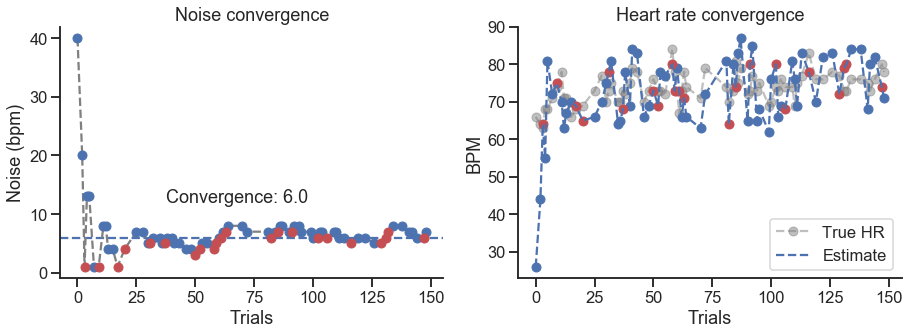

In [5]:
hrd_convergence(results_df[results_df.StairCond==0])
plt.savefig('clara_stari2.png', dpi=600)

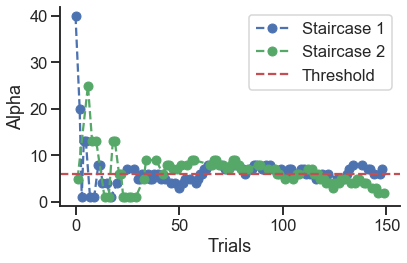

In [6]:
# staircase traces

tr1, = plt.plot(np.abs(results_df.Alpha[results_df.StairCond==0]), 'bo--')
tr2, = plt.plot(np.abs(results_df.Alpha[results_df.StairCond==1]), 'go--')
tr1.set_label('Staircase 1')
tr2.set_label('Staircase 2')

sns.despine()

# Convergence line
revers = np.abs(results_df.Alpha[results_df.Accuracy == 0])
conv = np.median(revers[~madmedianrule(revers)])
plt.axhline(y=conv, linestyle='--', color = 'r', label = 'Threshold')
#thresh.set_label('Threshold')
plt.legend()
# Text

#plt.text(len(results_df)/2, conv*2, 'Threshold: ' + str(conv))
plt.ylabel('Alpha')
plt.xlabel('Trials')

plt.tight_layout()
plt.savefig('staircases.png', dpi=600)

# Barplots

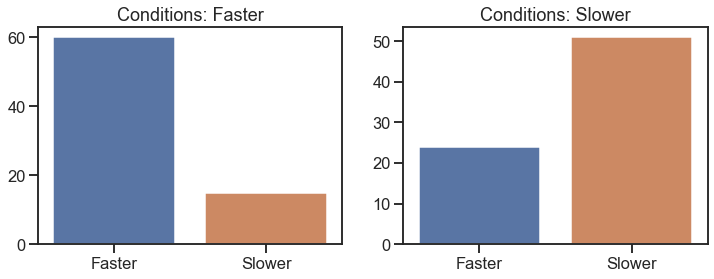

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
up = len(results_df[(results_df.Estimation == 'up') & (results_df.Condition == 'More')])
down = len(results_df[(results_df.Estimation == 'down') & (results_df.Condition == 'More')])
sns.barplot(x=['Faster', 'Slower'], y=[up, down])
plt.title('Conditions: Faster')

plt.subplot(122)
up = len(results_df[(results_df.Estimation == 'up') & (results_df.Condition == 'Less')])
down = len(results_df[(results_df.Estimation == 'down') & (results_df.Condition == 'Less')])
sns.barplot(x=['Faster', 'Slower'], y=[up, down])
plt.title('Conditions: Slower')
plt.savefig('HRD_barplot.png', dpi=600)

# Accuracy

In [8]:
len(results_df)

150

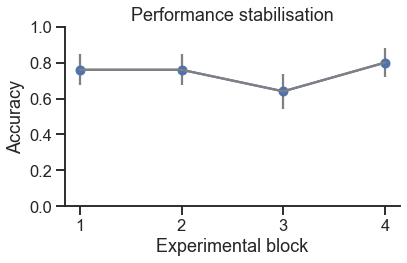

In [9]:
from scipy.stats import sem
mean, err = [], []
for x, i in enumerate(range(0, 100, 25)):
    mean.append(np.nanmean(results_df.Accuracy.iloc[i:i+25]))
    err.append(sem(results_df.Accuracy.iloc[i:i+25]))

plt.plot([1, 2, 3, 4], mean, 'o-')
plt.errorbar(x=[1, 2, 3, 4], y=mean,
             yerr=err, color='gray')
plt.ylim(0, 1)
sns.despine()
plt.xlabel('Experimental block')
plt.ylabel('Accuracy')
plt.title('Performance stabilisation')
plt.tight_layout()
plt.savefig('HRD_Accuracy.png', dpi=600)

# Confidence rating

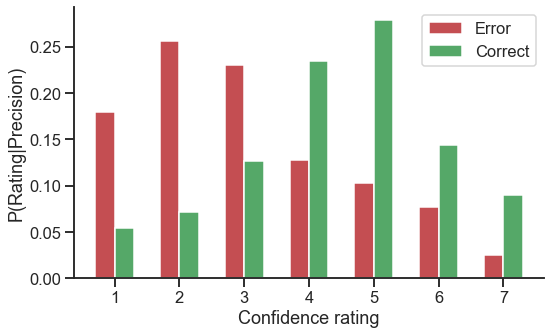

In [10]:
plot_confidence(results_df.Confidence, results_df.Accuracy)
plt.savefig('confidence2.png', dpi=600)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# Confidence
for conf in range(1, 8):
    # Correct trials
    p = sum((accuracy == 0) & (confidence == conf)) / sum(accuracy == 0)
    if conf == 1:
        plt.bar(conf-0.15, p, width=0.30, color='r', label='Error')
    else:
        plt.bar(conf-0.15, p, width=0.30, color='r')
    # Incorrect trials
    p = sum((accuracy == 1) & (confidence == conf)) / sum(accuracy == 1)

    if conf == 1:
        plt.bar(conf+0.15, p, width=0.30, color='g', label='Correct')
    else:
        plt.bar(conf+0.15, p, width=0.30, color='g')


plt.legend()
plt.ylabel('P(Rating|Precision)')
plt.xlabel('Confidence rating')
plt.xticks(range(1, 8))
sns.despine()
plt.tight_layout()
if path is not None:
    plt.savefig(path + 'confidence.png', dpi=600)

return fig, ax

Text(0, 0.5, 'P(Rating|Accuracy)')

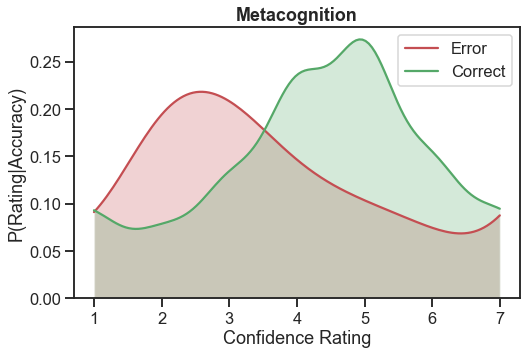

In [45]:
errConf = results_df.Confidence[results_df.Accuracy == 0]
corrConf = results_df.Confidence[results_df.Accuracy == 1]


plt.figure(figsize = (8,5))
sns.kdeplot(errConf, shade = True, label = 'Error', color = 'r', cut = 0)
sns.kdeplot(corrConf, shade = True, label = 'Correct', color = 'g', cut = 0)
plt.title('Metacognition', fontweight = 'bold')
plt.xlabel('Confidence Rating')
plt.ylabel('P(Rating|Accuracy)')



# Psychometric function using the BayesFit toolbox

References: http://www.slugocm.ca/bayesfit/

Text(0, 0.5, 'Proportion correct')

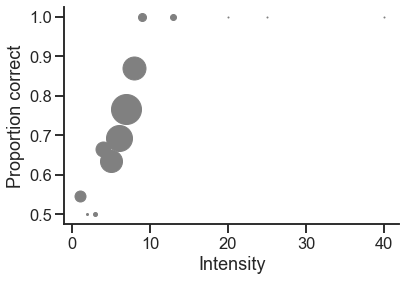

In [46]:
df = results_df.copy()
df.Alpha = np.abs(df.Alpha)
data = np.zeros((len(df.Alpha.unique()), 3))
for ii, intensity in enumerate(np.sort(df.Alpha.unique())):
    p = df[df.Alpha == intensity].Accuracy.mean()
    s= len(df[df.Alpha == intensity])
    plt.plot(intensity, p, marker='o', color='gray', markersize=s)
    
    # Store results
    data[ii, 0] = int(intensity)
    data[ii, 1] = int(len(df[(df.Alpha == intensity) & (df.Accuracy == 1)]))
    data[ii, 2] = int(len(df[(df.Alpha == intensity)]))

sns.despine()
plt.xlabel('Intensity')
plt.ylabel('Proportion correct')

In [47]:
import bayesfit as bf

In [48]:
# Define cumulative normal function to use as sigmoidal function
sigmoid_type = 'norm'

# List of logical arguments which correspond to: scale, slope, gamma, lambda
param_free = [True, True, False, False]

# Define priors for scale and slope parameters (here mu, and sigma)
priors = ['Norm(10,2)', 'Norm(20,2)', None, None]

# Fit model
metrics, options = bf.fitmodel(data, param_free = param_free, priors = priors, sigmoid_type = sigmoid_type)

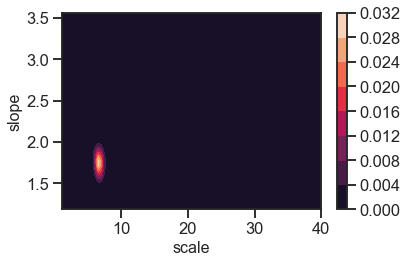

In [49]:
bf.plot_posterior(metrics)

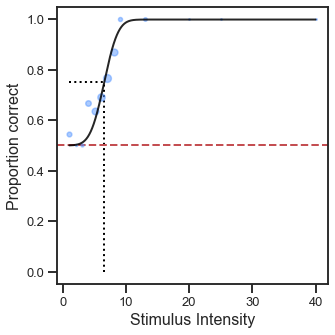

<Figure size 432x288 with 0 Axes>

In [50]:
fig = bf.plot_psyfcn(data, options, metrics)
plt.savefig('psychometric2.png', dpi=600)